# Yield Rate Gender Gap, Part 3: Adding Rankings
*This is Part 3 of an investigation into the yield rate disparity in college admissions between women and men. This is a personal project I started to help me tie together using python for web scraping, data cleaning, data visualization, hypothesis testing, statistical modeling, machine learning, and more. I appreciate feedback!*


Our previously scraped and cleaned CollegeData.com table contains a lot of admissions information for each school, but it doesn't contain anything about rankings. One of the most influential college rankings - for better or worse - are those put out by [US News and World Report](https://www.usnews.com/best-colleges/rankings).

US News keeps multiple ranking lists, tracking what they call 'National Universities', 'National Liberal Arts Colleges', 'Regional Universities' (which are split into four regions), and 'Regional Colleges' (also split into four regions). 

When scrolling down the page for each of these rankings, more rows will appear:


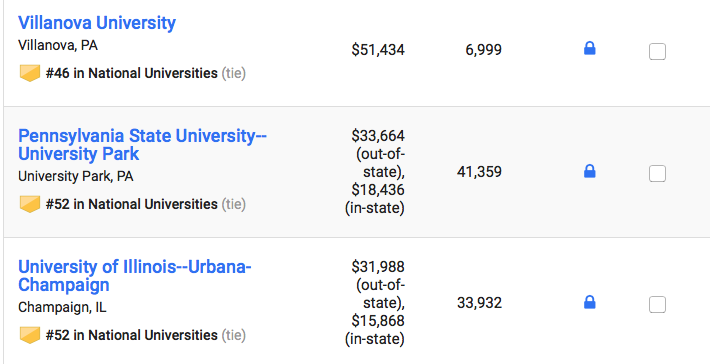
    

## Scraping US News with BeautifulSoup

After scrolling down until the schools are no longer ranked, I opened Safari's developer console and saved the generated HTML in its final state as a local .html files. I looked in the .html files to find the `<tr>` tags that correspond to a single row of results, and copied its attribute `data-view = "colleges-search-results-table-row"` to help identify all the `<tr>` tags each containing a row of rankigns data. I then used BeautifulSoup to scrape the page and return a pandas DataFrame.

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

filepath = 'data/usnews.html'
row_id_attr = {"data-view":"colleges-search-results-table-row"}
field_labels = ['Name','Location','Rank','Tuition','Undergrads']

scraped = []
with open(filepath,'r') as file:
    page = BeautifulSoup(file.read(), "lxml")
    for tag in page('tr', attrs = row_id_attr):
        values = list(tag.stripped_strings)
        if '(tie)' in values: values.remove('(tie)') # unwanted field
        if '1' in values: values.remove('1') # unwanted field
        scraped.append(dict(zip(field_labels, values)))

rankings = pd.DataFrame(scraped).replace('N/A',np.nan)

rankings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 5 columns):
Location      1400 non-null object
Name          1400 non-null object
Rank          1399 non-null object
Tuition       1393 non-null object
Undergrads    1276 non-null object
dtypes: object(5)
memory usage: 54.8+ KB


US News had rankings for 1400 schools. Each listing also contains the *tuition* and the *total number of undergraduates*, which are helpful pieces of data that we did not get from CollegeData.com (they were both available on another one of the five pages for each school that we didn't scrape).

We will want to join this new `'rankings'` DataFrame with our saved `'college'` DataFrame we scraped from CollegeData.com. We will discover that when we try to join tables on the `'Name'` that US News and CollegeData.com don't use the exact same names for each school, making it tricky to merge the tables together. 

---
## Cleaning the rankings
First, let's clean `'rankings'` column by column like we did for `'college'` back in Part 2.

We'll check the `.mode()` to find potential null values and replace them with `np.nan`:

Next, we'll extract the numeric `'Rank'` as well as save the `'Type'` of rank, that is, whether the school is a 'National University' or a 'Regional Colleges North', etc.  We will also drop any schools we accidentally scraped from the end of the list that did not contain a ranking.

In [2]:
rankings = rankings.drop(columns=['Tuition','Undergrads'])
rankings[['Rank']].head()

,Rank
0,#1 in Regional Colleges Midwest
1,#1 in Regional Colleges West
2,#1 in Regional Colleges North
3,#1 in Regional Universities Midwest
4,#1 in Regional Universities South


In [3]:
regexp = '([A-Z].*)$'
rankings['Type'] = rankings['Rank'].str.extract(regexp)
rankings['Type'] = rankings['Type'].fillna('Unranked')

unranked = rankings['Type'].str.contains('Unranked')
rankings = rankings.drop(rankings[unranked].index)
regional_colleges = rankings['Type'].str.contains('Regional Colleges')
rankings.loc[regional_colleges,'Type'] = 'Regional Colleges'
regional_universities = rankings['Type'].str.contains('Regional Universities')
rankings.loc[regional_universities,'Type'] = 'Regional Universities'

rankings['Type'] = rankings['Type'].astype('category')

rankings['Rank'] = rankings['Rank'].str.extract('#(\d*)').astype('float')
rankings = rankings.drop(rankings[rankings['Rank'].isnull()].index)

rankings[['Rank','Type']].head()

,Rank,Type
0,1.0,Regional Colleges
1,1.0,Regional Colleges
2,1.0,Regional Colleges
3,1.0,Regional Universities
4,1.0,Regional Universities


Next, we will split the `'City'` and `'State'` from the `'Location'` column before dropping it: 

In [4]:
rankings[['Location']].head()

,Location
0,"Grand Rapids, MI"
1,"Helena, MT"
2,"New York, NY"
3,"Omaha, NE"
4,"Elon, NC"


In [5]:
regexp = '(.*), ([A-Z]{2})'
rankings[['City','State']] = rankings['Location'].str.extract(regexp)
rankings['State'] = rankings['State'].astype('category')
rankings = rankings.drop(columns='Location')
rankings[['City','State']].head()

,City,State
0,Grand Rapids,MI
1,Helena,MT
2,New York,NY
3,Omaha,NE
4,Elon,NC


Like in Part 2, we'll append the `'State'` in parenthesis to any duplicated `'Name'`:

In [6]:
duplicated = rankings['Name'].duplicated(keep=False)
duplicated.sum()  # check num of duplicates

32

In [7]:
for i, row in rankings[rankings['Name'].duplicated(keep=False)].iterrows():
    rankings.loc[i,'Name'] += ' (' + row['State'] + ')'
    
rankings.loc[duplicated, 'Name'].duplicated(keep=False).sum() # check again

0

Finally, set the `'Name'` to be the DataFrame index.

In [8]:
rankings = rankings.set_index('Name', verify_integrity=True).sort_index()
rankings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1381 entries, Abilene Christian University to Youngstown State University
Data columns (total 4 columns):
Rank     1381 non-null float64
Type     1381 non-null category
City     1381 non-null object
State    1381 non-null category
dtypes: category(2), float64(1), object(1)
memory usage: 38.2+ KB


## Matching the names in both tables
We have our final cleaned `'rankings'` dataset from US News. Unfortunately, because of slight differences in our index `'Name'`, it won't be so straightforward to join `'rankings'` with our previously scraped `'college'` dataset from CollegeData.com.

In [9]:
# Import
college = pd.read_csv('data/collegedata_cleaned_backup.csv', 
                      index_col = 0, header = [0,1])

In [10]:
matched = rankings.index.isin(college.index)
matched.sum()

1093

1093 of the 1381 `'rankings'` names are listed verbatim in `'college'`. We will create a new temporary dataframe `'cleaned_rankings'` to hold them for now, and then drop them from `'rankings'`.

In [11]:
cleaned_rankings = rankings[matched]
rankings = rankings.drop(rankings[matched].index)
len(rankings)

288

## Using 'fuzzywuzzy' to match names
There is a high probability many of the remaining 288 unmatched names in `'rankings'` are written slightly differently than their yet-to-be-matched counterparts in `'college'`. Using [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy), which was put together by the people at SeatGeek and built on difflib, we can find a list of closest names in the `'college'` index for each name in the `'rankings'` table. We'll then check that the city of the matched `'college'` name lines up with the city in the `'rankings'` table, and if so, output the name to a new column callled `'Close Name'` that we'll visually inspect:

In [12]:
from fuzzywuzzy import process

def get_closest_name(row):
    close_names = process.extract(row.name, college.index)
    for close_name in close_names:
        if row['City'] == college.loc[close_name[0],('Location','City')]:
            return close_name[0]
    return np.nan

rankings['Close Name'] = rankings.apply(get_closest_name, axis=1)
rankings['Close Name'].count()

208

Using `'fuzzywuzzy.process.extract()'`, we got a `'Close Name'` for 208 of the remaining 288 names in `'rankings'`. To be safe, I'll visually look through these 208 name matches before renaming and joining. WARNING: Prepare for a wall of a table!

In [13]:
pd.set_option('display.max_rows', 208)
rankings[['Close Name']].dropna()

,Close Name
Name,
Aquinas College,Aquinas College (MI)
Arizona State University--Tempe,Arizona State University
Auburn University--Montgomery,Auburn University at Montgomery
Binghamton University--SUNY,Binghamton University
Brigham Young University--Idaho,Brigham Young University - Idaho
Brigham Young University--Provo,Brigham Young University
Bryn Athyn College of the New Church,Bryn Athyn College
CUNY--Hunter College,Hunter College
CUNY--John Jay College of Criminal Justice,John Jay College of Criminal Justice


The rare thing happened: the `'fuzzywuzzy.process.extract()'` and city check still managed to match a `'ranking'` name to a similar but incorrect `'college'` name that just happened to be in the same city - three times!:

- `'Florida A&M University'` was incorrectly matched to `'Florida State University'`, both in Tallahassee, FL. 

- `'Ohio State University--Columbus'` was incorrectly matched to `'Columbus State University'`, both in Columbus, OH.

- `'University of Lynchburg'` was incorrectly matched to `'Virginia University of Lynchburg'`, both in Lynchburg, VA.

By looking at all names in `'college'` for each city - or by just directly searching CollegeData.com - and running a Google search when needed, it only takes a minute to find that these schools should be changed as follows:

In [14]:
rankings.loc['Florida A&M University',
             'Close Name'] = 'Florida Agricultural and Mechanical University'
rankings.loc['Ohio State University--Columbus',
             'Close Name'] = 'Ohio State University'
rankings.loc['University of Lynchburg',
             'Close Name'] = 'Lynchburg College'

We can now rename the index of these successfully matched 208 rows to the successful `'Close Name'` field, drop `'Close Name'`, join them with `'college'`, and drop them from `'rankings'`.

In [15]:
matched = ~rankings['Close Name'].isnull()
rankings = rankings.rename(dict(rankings.loc[matched,'Close Name']))
matched = ~rankings['Close Name'].isnull()
rankings = rankings.drop(columns='Close Name')

cleaned_rankings = cleaned_rankings.append(rankings[matched])

rankings = rankings.drop(rankings[matched].index)

len(rankings)

80

## Even fuzzier matching

We have 80 rows left in `'rankings'` that haven't so far lined up with a row in `'college'`. Maybe there is an issue where the city is written different between the two tables - we can try using `'fuzzywuzzy.process.extract()'` again without checking the city this time.

In [16]:
def get_closest_name_modified(row):
    
    if row['City'] not in college['Location','City'].values:
        city = process.extract(row['City'], 
                               college['Location','City'].values)[0][0]
    else:
        city = row['City']
    
    names_in_city = college[college['Location','City'] == city].index

    close_names = process.extract(row.name, names_in_city)
    for close_name in close_names:
        if row['State'] == college.loc[close_name[0],('Location','State')]:
            return close_name[0]
    return np.nan

rankings['Close Name'] = rankings.apply(get_closest_name_modified, axis=1)
rankings['Close Name'].count()

66

Our modified function matched 66 of the 80 remaining names. Let's inspect the results. WARNING: Prepare for a slightly smaller wall of a table!

In [17]:
matched = ~rankings['Close Name'].isnull()
rankings.loc[matched, ['Close Name']]

,Close Name
Name,
Alderson Broaddus University,Alderson-Broaddus College
Atlanta Metropolitan State College,Carver College
Augsburg University,University of Minnesota Twin Cities
Augusta University,University of Phoenix Augusta Campus
Bay Path University,Bay Path College
Bay State College,Boston Architectural College
Bismarck State College,University of Mary
Brigham Young University--Hawaii,Brigham Young University - Hawaii
CUNY--Baruch College,Baruch College (City University of New York)


Some of these are obviously right or wrong, but many required searching Google and CollegeData.com to investigate. In many cases, the school has recently changed names. Unfortunately, for many cases the school is not listed in any way I could find on CollegeData.com. This process took significantly longer than the previous eye check - about 20 minutes of searching around. After manually renaming, let's see how many remain unmatched:

In [18]:
renamings = {
    "Atlanta Metropolitan State College": np.nan,
    "Augsburg University": "Augsburg College",
    "Augusta University": "Georgia Regents University",
    "Bay State College": np.nan,
    "Bismarck State College": np.nan,
    "CUNY--City College": "City College of New York",
    "CUNY--Medgar Evers College": 
        "Medgar Evers College (City University of New York)",
    "Dunwoody College of Technology": np.nan,
    "Georgia Southern University--Armstrong": "Armstrong State University",
    "Harvard University": "Harvard College",
    "Keiser University": np.nan,
    "Middle Georgia State University": np.nan,
    "Mount St. Joseph University": "College of Mount St. Joseph",
    "Notre Dame College of Ohio": "Notre Dame College",
    "Oklahoma State University Institute of Technology--Okmulgee": np.nan,
    "Pensacola State College": np.nan,
    "SUNY College of Technology--Canton": np.nan,
    "SUNY Polytechnic Institute--Albany/Utica": 
        "State University of New York Institute of Technology",
    "St. Joseph's College New York":"St. Joseph's College - Brooklyn Campus",
    "University of Holy Cross":"Our Lady of Holy Cross College",
    "University of North Texas at Dallas": np.nan,
    "University of Providence": np.nan,
}

rankings.loc[list(renamings.keys()), 'Close Name'] = list(renamings.values())

matched = ~rankings['Close Name'].isnull()
rankings = rankings.rename(dict(rankings.loc[matched,'Close Name']))
matched = ~rankings['Close Name'].isnull()
rankings = rankings.drop(columns='Close Name')

cleaned_rankings = cleaned_rankings.append(rankings[matched])

rankings = rankings.drop(rankings[matched].index)
len(rankings)

25

## No matches at all
There are 25 remaining schools in `'rankings'` that did not fuzzy match with any school name in `'college'`, including the 11 that we just previously found to not exist at CollegeData.com. The other 14 are:

In [19]:
rankings[~rankings.index.isin(list(renamings.keys()))][['City','State']]

,City,State
Name,,
Abraham Baldwin Agricultural College,Tifton,GA
Alabama Agricultural and Mechanical University,Normal,AL
Chipola College,Marianna,FL
College of St. Benedict,St. Joseph,MN
Cottey College,Nevada,MO
Crowley's Ridge College,Paragould,AR
DeVry University,Downers Grove,IL
Dean College,Franklin,MA
East Georgia State College,Swainsboro,GA


After some searching, two of these schools were indeed in CollegeData.com and were appropriately renamed. The notorious `'DeVry University'` *is* listed on CollegeData.com - but not as a single school. CollegeData.com has 14 separate listings whereas the US News ranking considers it a single school. Unfortunately, while CollegeData.com has 14 pages for these schools, there is no admissions data provided for a single one of them. Due to this, I just matched the DeVry `'rankings'` with the name `'DeVry University - Chicago'` in the `'college'` table. 

After making changes, let's see what remains:

In [20]:
renamings = {
    "Alabama Agricultural and Mechanical University": 
        "Alabama A&M University",
    "College of St. Benedict": "College of Saint Benedict",
    "DeVry University":"DeVry University - Chicago"
}

rankings.loc[list(renamings.keys()), 'Close Name'] = list(renamings.values())

matched = ~rankings['Close Name'].isnull()
rankings = rankings.rename(dict(rankings.loc[matched,'Close Name']))
matched = ~rankings['Close Name'].isnull()
rankings = rankings.drop(columns='Close Name')

cleaned_rankings = cleaned_rankings.append(rankings[matched])

rankings = rankings.drop(rankings[matched].index)
len(rankings)

22

We'll return to these 22 unmatched schools in a moment.

## Final inspection of cleaned rankings

For now, let's check our `'cleaned_rankings'` for any anomolies before we join it with `'college'`. First, let's see if there are any duplicates:

In [21]:
duplicated = cleaned_rankings.index.duplicated(keep=False)
cleaned_rankings[duplicated][['City','State']]

,City,State
Name,,
Concordia College,Bronxville,NY
Concordia College,Moorhead,MN


In terms of `'college'` names, the Concordia in Bronxville, NY should be `'Concordia College New York'` - the other one can stay as is.

In [22]:
second_duplicate = cleaned_rankings.index.duplicated(keep='last')
cleaned_rankings[second_duplicate]

idx = cleaned_rankings.index
idx = idx.where(~idx.duplicated(keep='last'), idx + ' New York')
cleaned_rankings.index = idx

cleaned_rankings[duplicated][['City','State']]

,City,State
Name,,
Concordia College New York,Bronxville,NY
Concordia College,Moorhead,MN


Let's see any cities that don't line up between the two tables:

There's nothing worrying here - I double checked that 'Riverdale' is a neighborhood in the 'Bronx', 'Laie' is on Oahu, 'South Euclid' is next to 'Cleveland', and 'Normal' is the post office name of the site of Alabama A&M inside 'Huntsville'. Also recall we matched DeVry to the Chicago one.

## What's being left behind?

Before we continue, let's consider the 22 umatched schools that still remain in the uncleaned `'rankings'` table that aren't able to come along with the join. Many of them are recently converted community colleges though some, for whatever reason, just aren't in the source dataset CollegeData.com used. 

Let's look at how big of a chunk these schools represent from our rankings in terms of undergrad population:

It seems that the `'Regional Colleges'` rank category in our soon-to-be-joined `'college'` data set will be 18% short in terms of undergrads, but our other rank categories will be missing less than 1%.

## Joining the tables

Finally, on with the join:

In [23]:
cleaned_rankings = cleaned_rankings.drop(columns=['City','State'])
cleaned_rankings.columns = [['Rank','Category'],['Rank Number','Rank Type']]
college = college.join(cleaned_rankings)

That's it!

We'll add a new rank category `'Unranked'` for those schools in `'college'` that were not on a US News ranking list, and then we'll export the the whole thing to a .csv file:

In [24]:
college['Category','Rank Type'] = college['Category','Rank Type'] \
                                            .cat.add_categories('Unranked')
college['Category','Rank Type'] = college['Category','Rank Type'] \
                                            .fillna('Unranked')

college.to_csv('data/college.csv')

Now that our college admissions data is scraped, cleaned, and joined with rankings data, the hard part is over. We'll move on to exploratory data analysis in the next post.